**TP Filtre de Kalman**

L'objectif de ce TP est la mise en place d'un système d'assimilation de données par filtre de Kalman, pour l'équation des ondes 1D :

$$\displaystyle{\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0},$$

avec les conditions aux limites de Dirichlet homogène.

On propose d'utilsier le $\theta$-schéma, ce qui conduit au schéma à deux niveaux suivant :

$$\left[ \begin{array}{l} U^{n+1}\\ U^n\end{array}\right]=\left[ \begin{array}{ll} B^{-1}A&-I\\ I&0\end{array}\right]\left[ \begin{array}{l} U^{n}\\ U^{n-1}\end{array}\right] \quad \mbox{ et }  \quad  U^1=U^0,$$

avec les matrices $A$ et $B$ definies par $A=c^2 \mbox{Tridiag}([1-2\theta,2/c^2-2+4\theta,1-2\theta])$ et $B=c^2 \mbox{Tridiag}([\theta,1/c^2+2\theta,-\theta])$.

On suppose disposer d'observations de certaines composantes de la solution $u$ à différents instants selon le modèle

$$y_n=\mathcal{H}(U^{n})+\epsilon^o_n, \quad \mbox{ avec } \quad \epsilon^o_n \sim \mathcal{N}(0, R).$$

Les matrices de covariance d'erreur d'ébauche $P_0$ (associée à U^0), d'observation $R$ et de modèle $Q$ seront suposées des multiples de l'identité. On s'intéressera également à l'impact sur la qualité de prédiction des variances de ces erreurs.

*Sources*: ce TP s'inspire des notebooks d'E. Cosme (UGA) et codes Matlab de S. Gratton (Toulouse INP).


In [1]:
import numpy as np
import math
import scipy as scp
import scipy.sparse as scps
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#-------------------------------------------------------
# Onde 1D
#-------------------------------------------------------

class wave1D:

    def __init__( self, t_init = 0, t_stop = 2500, sigbq=[1.,1.],assim_mode='T'):
        self.t_init = t_init
        self.t_stop = t_stop
        # Mode ébauche/assimilation ou référence
        self.assim_mode=assim_mode

        # paramètres de la grille
        self.L=1.0
        self.nx = 500
        self.dt = 0.0001
        self.dx=self.L/(self.nx-1)
        self.n=len(np.arange(0,self.L,self.dx))

        # schéma numérique : théta schéma
        self.theta=0.5

        # schéma numérique : paramètre de A et B
        c=self.dt/self.dx
        self.triA=[c**2*(1-2*self.theta), 2-2*c**2+4*c**2*self.theta, c**2*(1-2*self.theta)]
        self.triB=[-c**2*self.theta,1+2*c**2*self.theta,-c**2*self.theta]

        # Variance des erreurs d'ébauche et de modèle
        self.sigb=sigbq[0]
        self.sigq=sigbq[1]

        # Conditions initiales : x, P0, Q
        self.xvar,self.Pf,self.Q = self.initial_condition()

        # Evolution de x et Pf : stockage pour diagnostics
        self.xvar_series = np.zeros((self.nx,t_stop-t_init+1))
        self.Pf_series=np.zeros((self.nx,self.nx,t_stop-t_init+1))
        self.time = 0.
        self.time_series = np.zeros((t_stop-t_init+1,)).astype(int)

    def initial_condition(self):
        """Conditions initiales : calcul de x0/xb,P0,Q"""
        xout = np.zeros((2*self.nx,))
        ii=np.arange(round(4.5*self.n/10),round(5.5*self.n/10),1)
        xdeb= round(4.5*self.n/10)*self.dx
        xfin=round(5.5*self.n/10)*self.dx

        if (self.assim_mode=='T'):
            # ébauche
            for k in ii:
                xout[k]=(1-math.sin((k*self.dx-xdeb)*math.pi*20))
            xout[self.nx:]=xout[0:self.nx]
        else:
            # solution de référence :
            for k in ii:
                xout[k]=(1-math.cos((k*self.dx-xdeb)*math.pi*20))
            xout[self.nx:]=xout[0:self.nx]

        # calcul de pout, qout et bruitage de l'ébauche
        pout = self.sigb*np.kron(np.ones((2,2)),np.eye(self.nx))
        qout = self.sigq*math.sqrt(self.dt)*np.eye(N=self.nx)
        if (self.assim_mode=='T'):
            for k in ii:
                xout[k]=(1-math.sin((k*self.dx-xdeb)*math.pi*20))
            xout[0:self.nx]+= np.random.multivariate_normal(np.zeros(self.nx),pout[0:self.nx,0:self.nx])
            xout[self.nx:]=xout[0:self.nx]

        return xout,pout,qout


    def time_step(self, x_in, t_in):
        """Evolution temporelle sur un pas de temps"""

        x_out = np.zeros_like(x_in)

        #Construction des matrices A et B
        data=np.array([self.triA[0]*np.ones((self.nx,)),self.triA[1]*np.ones((self.nx,)),self.triA[2]*np.ones((self.nx,)) ])
        diags=np.array([-1,0,1])
        A=scps.spdiags(data,diags,self.nx,self.nx)
        data=np.array([self.triB[0]*np.ones((self.nx,)),self.triB[1]*np.ones((self.nx,)),self.triB[2]*np.ones((self.nx,)) ])
        diags=np.array([-1,0,1])
        B=scps.spdiags(data,diags,self.nx,self.nx)

        # Calcul de x
        x_out[0:self.nx]=sla.spsolve(B,A*x_in[0:self.nx])-x_in[self.nx:]
        x_out[self.nx:]=x_in[0:self.nx]

        # Ajout de l'erreur modèle pour la solution de référence
        if self.assim_mode != 'T':
                x_out[0:self.nx] += np.random.multivariate_normal(np.zeros(self.nx), self.Q)

        # Sauvegarde de la date
        self.time = t_in

        return x_out

    def forecast(self, t_start = None, t_end = None):
        """Prévision entre deux instants"""
        """Evolution de l'état et de la matrice de covariance d'erreur de prévision"""

        # Initialisation
        if t_start == None or t_end == None:
            t_start = self.t_init
            t_end = self.t_stop
        nstep = t_end - t_start

        # Boucle d'évolution de t_start à t_end
        for day in range(t_start, t_end):
            iday = day - self.t_init
            if iday < 0:
                print('Inconsistence entre les temps de début et de fin de la fenêtre')

            ## Prévision du vecteur d'état
            self.xvar = self.time_step(self.xvar, day)

            #stockage du vecteur d'état
            self.xvar_series[:,iday] = self.xvar[0:self.nx]
            self.time_series[iday] = self.time

            ## Prévision de la matrice de covariance d'erreur
            ## Uniquement en mode assimilation
            if self.assim_mode == 'T':
                ### Décomposition racine carré
                U, s, V = np.linalg.svd(self.Pf)
                S = np.diag(np.sqrt(s))
                smat=np.inner(U,S)
                ### Propagation des colonnes au cours du ttemps
                for ix in range(self.nx):
                    smat[:, ix] = self.time_step(smat[:,ix], day)
                ### Assemblage de Pf
                self.Pf = np.dot(smat, smat.T)
                self.Pf[0:self.nx,0:self.nx]+=self.Q
                self.Pf_series[:, :, iday] = self.Pf[0:self.nx,0:self.nx]

    def plot(self,it):
        plt.figure(figsize=(12,8))
        plt.plot(self.xvar_series[:,it],'black',linewidth=1.)
        plt.show()



/home/sara/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


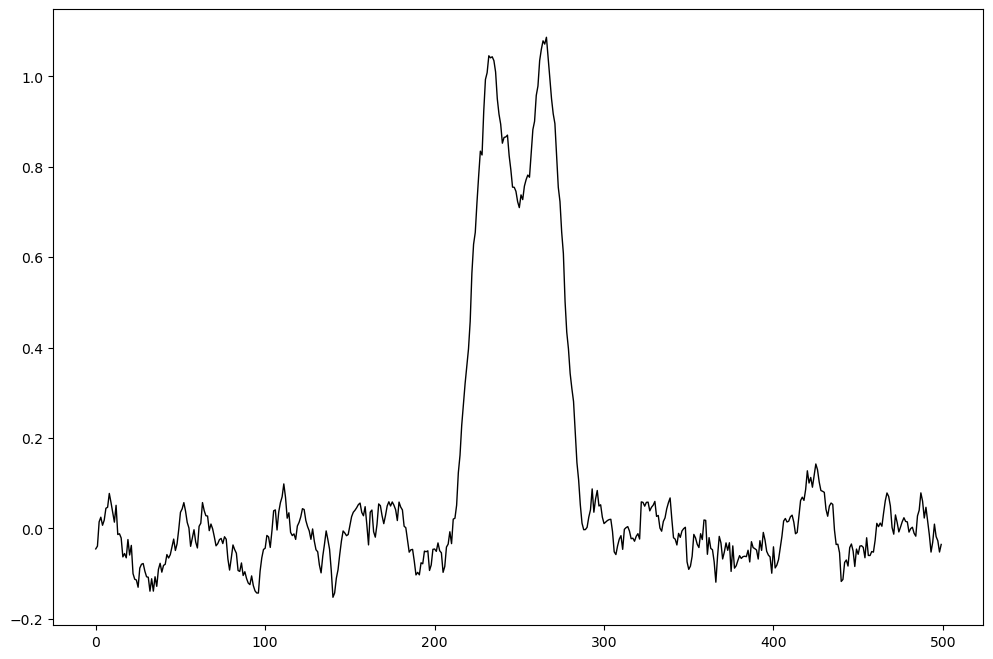

In [3]:
t_start, t_end = 0, 300
ntime = t_end -t_start

# Evolution de la solution de référence
W1D_ref=wave1D(t_init = t_start, t_stop = t_end, sigbq=[1e-6,1e-6],assim_mode='F')
W1D_ref.forecast()
W1D_ref.plot(it=t_end-1)

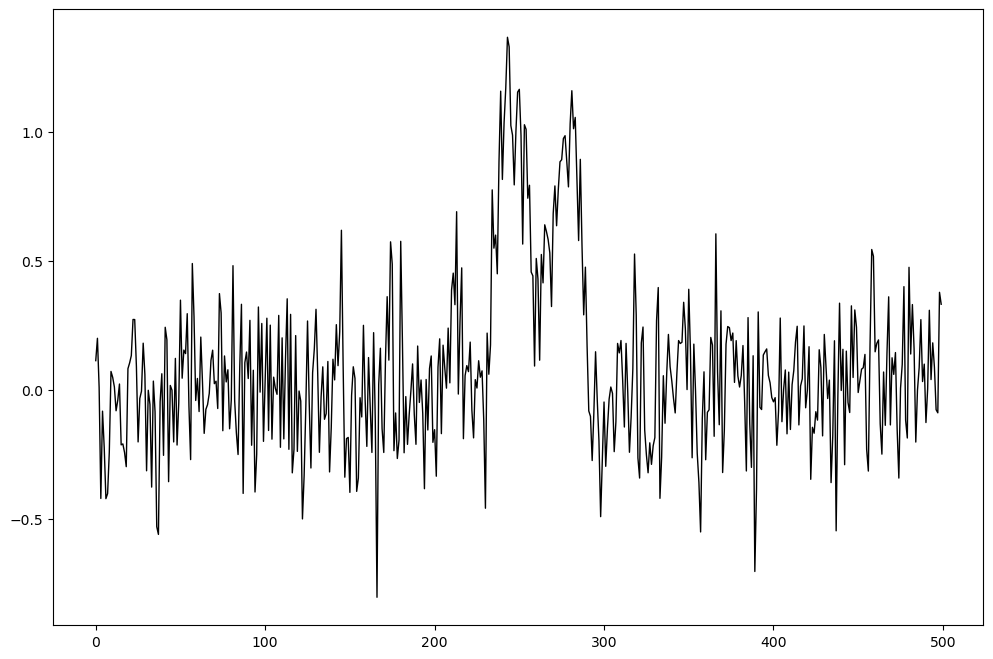

In [4]:
# Evolution de l'ébauche
W1D_bkg=wave1D(t_init = t_start, t_stop = t_end, sigbq=[1e-1,1e-6],assim_mode='T')
W1D_bkg.forecast()
W1D_bkg.plot(it=t_end-1)

In [84]:

# Construction de l'opérateur d'observation H
# On suppose que l'on observe directement, et de manière régulière la référence à instant donné

def H(v, obs_step = 5):
    n = int(len(v)/2)
    mat2 = np.zeros((int(n/obs_step), n))
    mat1 = np.zeros((int(n/obs_step), n))

    for l in range(mat1.shape[0]):
        if l == 0:
            continue
        for c in range(mat1.shape[1]):
            if c/l == obs_step:
                mat1[l][c] = 1
    mat1[0][0] = 1
    return (np.concatenate((mat1, mat2), axis=1))

# Localisation temporelle des étapes analyse
# On suppose des fenêtres de prévision de mêmes durées
# On commencera la phase d'assimilation à partir de 100 pas de temps

def T(t_end, time_step = 50):
  return np.arange(time_step,t_end +1, time_step)

In [85]:
# Analyse BLUE
def analysis(xf,Pf,yobs,Robs,Hobs):
    """Calcul de l'analyse"""
    """Calcul de xa et Pa"""
    K = Pf@Hobs.T@np.linalg.inv(Hobs@Pf@Hobs.T+Robs)

    xa = xf + K@(yobs-Hobs@xf)
    Pa = Pf - K@Hobs@Pf
    return xa,Pa

50
100
150
200
250
300


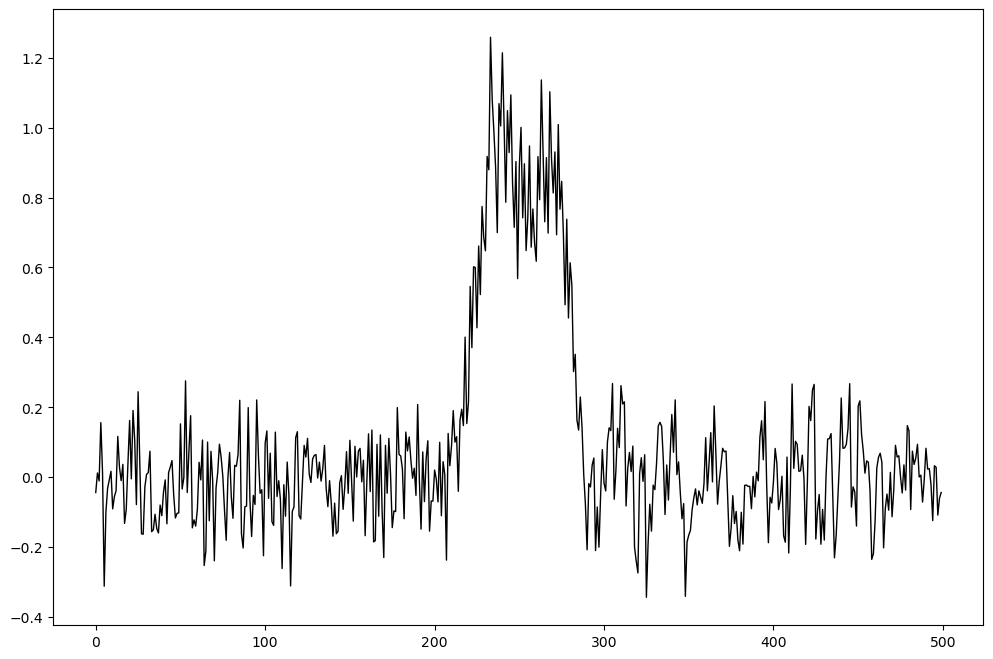

In [89]:
# Simulation avec assimilation de données par filtrage de Kalman
t_start, t_end = 0, 300
W1D_KF = wave1D(t_init = t_start, t_stop = t_end,sigbq=[1e-1,1e-6],assim_mode='T')
T_ = T(t_end)
sigma = 0.01
t_start = 0
# Boucle d'évolution de tstart à tend
for t in list(T_):
    print(t)
    W1D_KF.forecast(t_start=t_start, t_end = t)
    xf = W1D_KF.xvar
    xobs = W1D_ref.xvar_series[:,t]
    H_mat = H(xf)
    p = H_mat.shape[0]
    n = int(H_mat.shape[1]/2)
    Hobs = H_mat[:, :n]@xobs
    Robs = (sigma**2)*np.identity(p)
    yobs = Hobs + np.random.multivariate_normal(np.zeros(p), Robs)
    Pf = W1D_KF.Pf
    xf_new, Pf_new = analysis(xf,Pf,yobs,Robs,H_mat)
    W1D_KF.Pf = Pf_new
    W1D_KF.xvar = xf_new
    W1D_KF.Pf_series[:,:,t] = Pf_new[:n,:n]
    W1D_KF.xvar_series[:,t] = xf_new[:n]
    t_start = t


## Affichage
W1D_KF.plot(it=t_end-1)


RMS bkg= 0.3185732448525069 RMS KF= 0.229811840671987


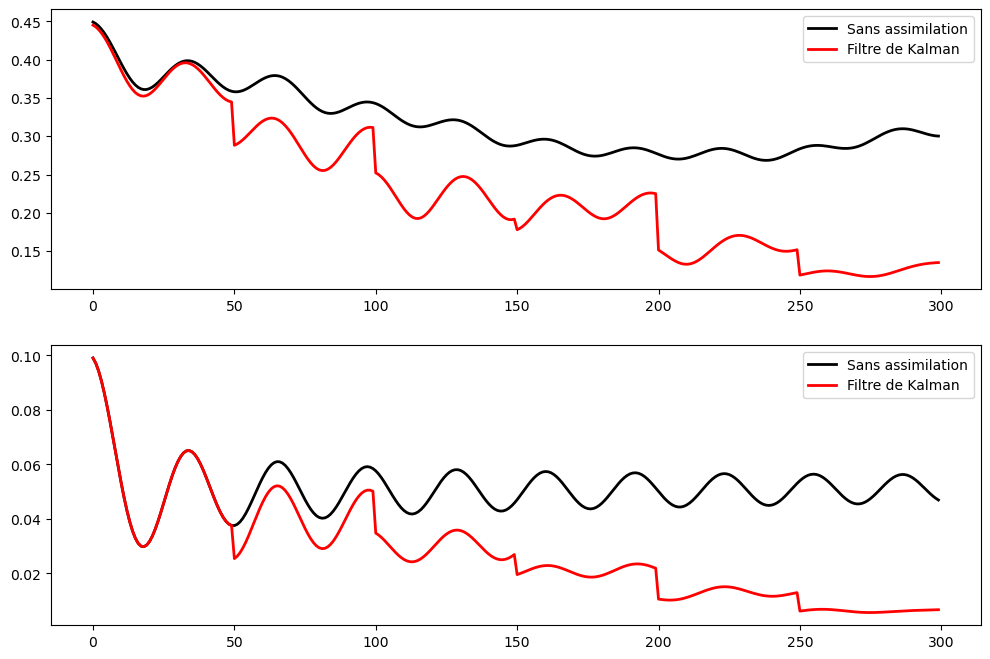

In [93]:
#Erreur RMS normalisée et trace des matrices de covariance d'erreur

nday=len(W1D_ref.xvar_series[0,:])
RMS_bkg_series=np.zeros((nday-1,))
RMS_bkg=0
VAR_bkg_series=np.zeros((nday-1,))
RMS_KF_series=np.zeros((nday-1,))
RMS_KF=0
VAR_KF_series=np.zeros((nday-1,))

for t in range(nday-1):
    # Différence entre les séries pour le background
    diff_bkg = W1D_bkg.xvar_series[:, t] - W1D_ref.xvar_series[:, t]
    RMS_bkg_series[t] = np.sqrt(np.mean(diff_bkg**2))  # Calcul de l'erreur RMS
    VAR_bkg_series[t] = np.mean(np.diag(W1D_bkg.Pf_series[:,:,t]))  # Trace de la matrice de covariance

    # Différence entre les séries pour le filtre de Kalman
    diff_KF = W1D_KF.xvar_series[:, t] - W1D_ref.xvar_series[:, t]
    RMS_KF_series[t] = np.sqrt(np.mean(diff_KF**2))  # Calcul de l'erreur RMS
    VAR_KF_series[t] = np.mean(np.diag(W1D_KF.Pf_series[:,:,t]))  # Trace de la matrice de covariance

RMS_bkg = np.mean(RMS_bkg_series)
RMS_KF = np.mean(RMS_KF_series)

print('RMS bkg=',RMS_bkg,'RMS KF=',RMS_KF)

bkg_time = W1D_bkg.time_series
plt.figure(figsize=(12,8))
legend=['Sans assimilation','Filtre de Kalman']
plt.subplot(2, 1, 1)
plt.plot(bkg_time[0:nday-1],RMS_bkg_series[:],'black',label=legend[0], linewidth=2)
plt.plot(bkg_time[0:nday-1],RMS_KF_series[:],'red',label=legend[1],linewidth=2)
plt.legend()
plt.subplot(2,1,2)
plt.plot(bkg_time[0:nday-1],VAR_bkg_series[:],'black',label=legend[0], linewidth=2)
plt.plot(bkg_time[0:nday-1],VAR_KF_series[:],'red',label=legend[1],linewidth=2)
plt.legend()
plt.show()